<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords, wordnet
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col = 0)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [4]:
data.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [5]:
#проверим пропуски
data.isna().sum()

text     0
toxic    0
dtype: int64

In [6]:
#проверим дубликаты
data.duplicated().sum()

0

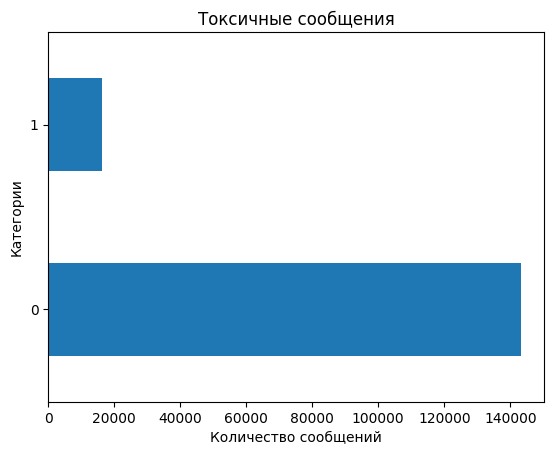

In [7]:
#посмотрим диаграмму
data['toxic'].value_counts().plot(kind='barh')
plt.title('Токсичные сообщения')
plt.xlabel('Количество сообщений')
plt.ylabel('Категории')
plt.show()

In [8]:
#загрузим пакет со списком стоп-слов
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\karma\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\karma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
lemmatizer = WordNetLemmatizer()

In [10]:
#напишем функцию для очистки текста
def get_wordnet_pos(tag):
    tag = tag[0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN, 
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def clear_text_with_pos(text):
    text = re.sub(r'[^a-zA-z\' ]', ' ', text)
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    lemmatized_words = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in pos_tags if word not in stop_words]
    cleaned_text = ' '.join(lemmatized_words)
    return cleaned_text

data['text'] = data['text'].apply(clear_text_with_pos)

In [11]:
data.head()

,text,toxic
0,explanation edits make username hardcore metal...,0
1,d'aww match background colour 'm seemingly sti...,0
2,hey man 'm really try edit war 's guy constant...,0
3,ca n't make real suggestion improvement wonder...,0
4,sir hero chance remember page 's,0


In [12]:
#разделим выборки
target = data['toxic']
features = data['text']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.1, stratify = target, random_state=12345)

In [13]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(143362,)
(15930,)
(143362,)
(15930,)


**Вывод:**
- данные обработаны, очищены от лишних символов, лемматизированы, токенизированы, разбиты на выборки

## Обучение

In [14]:
def training(model, params):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df = 1)),
        ('model', model)])
    grid = GridSearchCV(pipeline, cv = 5, n_jobs = -1, param_grid = params ,scoring = 'f1', verbose = False)
    grid.fit(features_train, target_train)
    print('Лучший результат:', grid.best_score_)
    print('Лучшие параметры:', grid.best_params_)
    return grid

In [15]:
%%time

lr_model = training(LogisticRegression(), {
    'model__C':[0.1, 1.0, 10.0],
    'model__penalty':["l2"]
})

Лучший результат: 0.7774529438039229
Лучшие параметры: {'model__C': 10.0, 'model__penalty': 'l2'}
CPU times: total: 30.6 s
Wall time: 42.2 s


In [16]:
%%time

dtc_model = training(DecisionTreeClassifier(), {
    'model__criterion':['gini','entropy'],
    'model__max_depth':[2,4,6]
})

Лучший результат: 0.5474319090709714
Лучшие параметры: {'model__criterion': 'gini', 'model__max_depth': 6}
CPU times: total: 17.4 s
Wall time: 59.2 s


In [17]:
%%time

cat_model = training(CatBoostClassifier(logging_level='Silent'), {
    'model__depth': [4,6],
    'model__learning_rate' : [0.01,0.03],
    'model__iterations' : [1, 10]
})

Лучший результат: 0.39093708538051214
Лучшие параметры: {'model__depth': 4, 'model__iterations': 10, 'model__learning_rate': 0.01}
CPU times: total: 1min 31s
Wall time: 3min 57s


лучший результат на тренировочной выборке у LogisticRegression, поэтому протестируем её на тестовой выборке

In [18]:
lr_test = f1_score(target_test, lr_model.predict(features_test))
print("Результат LogisticRegression", lr_test)

Результат LogisticRegression 0.7938356164383561


## Общий вывод

- загрузили и изучили данные
- обработали данные
- очистили от лишних символов
- лемматизировали, токенизировали
- обучили три модели: LogisticRegression, DecisionTreeClassifier, CatBoostClassifier
- выбрали лучшую модель на тренировочной выборке, ей оказалась LogisticRegression
- протестировали LogisticRegression на тестовой выборке
- получили f1_score модели LogisticRegression на тестовой выборке равной 0.78